# Toy Modelling of Phase Jumps
This notebook aims to show the impact of white noise in the signal and
how that translates to noise in the phase

In [1]:
# . Honours Module Folder
# ├ FYPLibrary
# | ├ file_reading.py
# | └ IQ_demod.py
# └ Sub Project folder i.e.: os.path.abspath('')
#   ├ this notebook(.ipynb)
#   └ "Batch" folder
#     └ C2-xxxHz-xxxmVpp-80.125xxxMHz-comment.txt

# Initialization: Directory appending for my system. Vary the directories as necessary.
import sys
import os.path
# Add the FYPLibrary folder in the same level as this folder.
parent_dir = os.path.dirname(os.path.abspath(''))
if os.path.join(parent_dir, 'FYPLibrary') not in sys.path:
    sys.path.append(os.path.join(parent_dir, 'FYPLibrary'))
del parent_dir

# from pprint import pprint
# pprint(sys.path)

# within this jupyter notebook
from os import listdir
from file_reading import *
from IQ_demod import *
import numpy as np
import matplotlib.pyplot as plt
from numpy import random as rd
from numpy import pi
from scipy.signal import periodogram
from scipy.stats import cauchy

Define perlin noise centered at 0 for fluctuating $\delta L$.

https://stackoverflow.com/questions/47837968/how-to-make-a-smoother-perlin-noise-generator
```python
def Perlin(self, lenght_axes, octaves, zoom = 0.01, amplitude_base = 0.5):
    result = []
    
    for y in range(lenght_axes):
        line = []
        for x in range(lenght_axes):
            value = 0
            for o in range(octaves):
                frequency = 2 ** o
                amplitude = amplitude_base ** o
                value += self.Interpolate_Noise(x * frequency * zoom, y * frequency * zoom) * amplitude
            line.append(value)
        result.append(line)
        print(f"{y} / {lenght_axes} ({y/lenght_axes*100:.2f}%): {round(y/lenght_axes*20) * '#'} {(20-round(y/lenght_axes*20)) * ' '}. Remaining {lenght_axes-y}.")
    return result
```
We need to numpify this.

Define a type of noisy signal

In [38]:
# intialisation
rd.seed(1337) # seed random
SIGNAL_F = 70.125e6*2 #Hz 
SAMPLING_F = 1.0e6 #Hz
N, _ = freq_ratio(signal=SIGNAL_F, sample=SAMPLING_F)
ph_ad = phase_advance(SIGNAL_F, SAMPLING_F) # phase advance = 2*pi/N
print(f"[Int Debug] {N = }, {ph_ad = }")
# amp_V = 0.115 # amplitude of V
# phi_0 = 0.163 # radian associated with t = 0
# mirror_f = 10 # freq of oscillation of mirror
# mirror_A = 1e-6 # amplitude of oscillating mirror
# rel_noise = 0.0015527 # noise of real random relative to ampV
# phase_noise = 4.6267e-2 # noise of mirror amplitude relative to miror_A
# p_mirror = 0.000016 # fraction of phase_noise being non-0
# t_max = 8 #s

amp_V = 0.115 # amplitude of V
phi_0 = 0.163 # radian associated with t = 0
mirror_f = 0.5 # freq of oscillation of mirror
mirror_A = 0.8 # amplitude of oscillating mirror
rel_noise_amp = 0.00155 # amplitude of noise of detector 
rel_noise_std = np.sqrt(1/SAMPLING_F) # std deviation
phase_noise_amp = 6 # noise of mirror amplitude relative to miror_A
phase_std = np.sqrt(1/SAMPLING_F) # std_deviation
t_max = 4 #s

t_axis = np.arange(0, t_max, 1/SAMPLING_F)
len_t_axis = len(t_axis)

[Int Debug] N = 4, ph_ad = 1.5707963267948966


1. We initial consider a signal model (including mirror oscillation) of just detector noise, this just gives us $$ V(t) = A \sin(2\pi f_{2\Omega}t + \phi_0 + B\sin(2\pi f_{\text{Mirror}} t) ) + C\xi_{[-1, 1]}, $$
where $A$, $B$, $C$ are the strength of voltage oscillations, mirror oscillations and noise respectively, and $\xi_{[0, \sigma]}$ is the random variable defined by the normal distribution $\mathcal{N}(0, \sigma^2)$.

2. We consider noise in the fibre (hence phase) as just a random variable.


3. We now consider the change as fibre length as a random variable, and the fibre length to therefore be an integral of it. $$V(t)$$ This has given a much more realistic signal FFT, but the $\phi_d$ becomes a random walk, which clearly should not be the case.

4. The change in fibre length should therefore still be centered at 0, and not vary as quickly on the order of dt, we opt for a biased noise at time step to mimic the restoring force tendency.

In [39]:
# model 1
# signal = amp_V * np.sin(2*pi*rd.default_rng().normal(loc= SIGNAL_F, scale= 1e0, size= len_t_axis) * t_axis + phi_0 \
#     + mirror_A * np.sin(2*pi*mirror_f * t_axis) \
#     + rd.default_rng().uniform(-phase_noise,phase_noise) ) \
#     + amp_V * rd.default_rng().uniform(-rel_noise, rel_noise, size= len_t_axis)
# model 2
# signal = amp_V * np.sin(2*pi*SIGNAL_F * t_axis + phi_0 \
#     + mirror_A * (np.sin(2*pi*mirror_f * t_axis) + \
#         phase_noise_amp * rd.default_rng(13).normal(0, phase_std, size= len_t_axis))) + \
#     rel_noise_amp * rd.default_rng(2).normal(0, rel_noise_std, size= len_t_axis)
# model 2a
# signal = amp_V * np.sin(2*pi*SIGNAL_F * t_axis + phi_0 \
#     + mirror_A * (np.sin(2*pi*mirror_f * t_axis) + \
#     rd.default_rng().uniform(-0.2, 0.2, size= len_t_axis) \
#     + 0.0*rd.default_rng().normal(0,0.1, size= len_t_axis))) \
#     + amp_V * rd.default_rng().uniform(-rel_noise, rel_noise, size= len_t_axis)
# model 2b
# signal = amp_V * np.sin(2*pi*SIGNAL_F * t_axis + phi_0 \
#     + mirror_A * (np.sin(2*pi*mirror_f * t_axis)) + \
#         rel_noise*rd.default_rng(13).normal(0, phase_noise, size= len_t_axis)) + \
#     amp_V * rel_noise * rd.default_rng(2).normal(0, phase_noise, size= len_t_axis)
# model 3
signal = amp_V * np.sin(2*pi*SIGNAL_F * t_axis + phi_0 \
    + mirror_A * (np.sin(2*pi*mirror_f * t_axis) + \
        phase_noise_amp * np.cumsum(rd.default_rng().normal(0, phase_std, size= len_t_axis)))) + \
    rel_noise_amp * np.cumsum(rd.default_rng().normal(0, rel_noise_std, size= len_t_axis))

# model 4 (slower dW)
# signal = amp_V * np.sin(2*pi*SIGNAL_F * t_axis + phi_0 \
#     + mirror_A * np.sin(2*pi*mirror_f * t_axis) + np.cumsum(
#         rd.default_rng().binomial(1, p_mirror, size= len_t_axis) \
#         * rd.default_rng().normal(0, phase_noise, size= len_t_axis))) \
#     + amp_V * rd.default_rng().uniform(-rel_noise, rel_noise, size= len_t_axis)
# model 5 (perlin noise)

# mdoel 6 cauchy noise
# signal = amp_V * np.sin(2*pi*SIGNAL_F * t_axis + phi_0 \
#     + mirror_A * np.sin(2*pi*mirror_f * t_axis)  \
#     + cauchy.rvs(0, 0.06, size= len_t_axis)) + \
#     amp_V * rd.default_rng().normal(0, rel_noise, size= len_t_axis)

phases = signal_to_phase(signal, N, ph_ad, phase_advancement_correction= False)
phases = phase_reconstruction_2(phases, ph_ad)

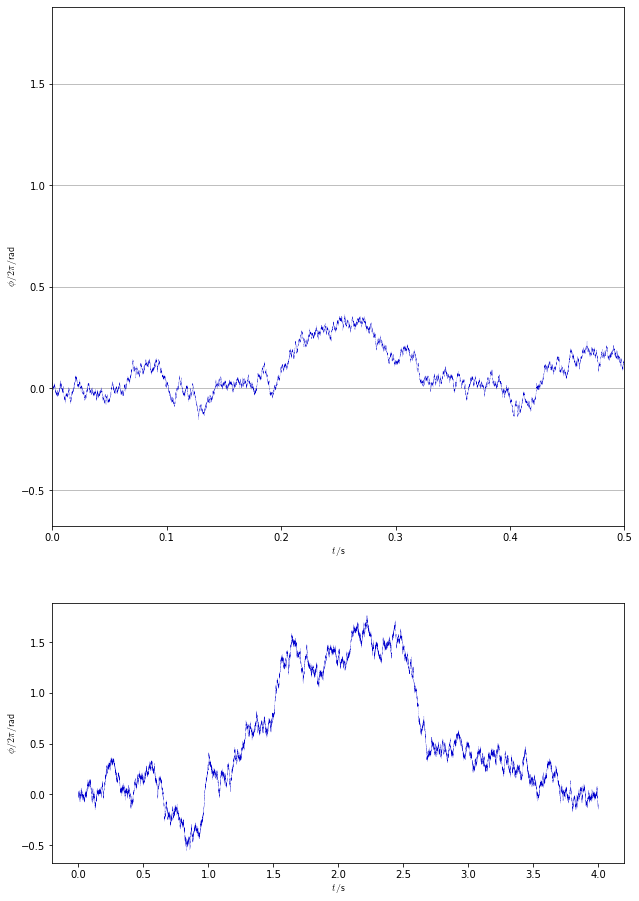

In [40]:
fig, axs = plt.subplots(nrows=2, ncols=1, gridspec_kw={'height_ratios': [2, 1]})
ax = axs[0]
ax.plot(t_axis[:1-N], phases/(2*pi), color = 'mediumblue', linewidth= 0.1)
ax.set_ylabel(r'$\phi/2\pi$/rad', usetex = True)
ax.set_xlabel(r'$t$/s', usetex = True)
ax.set_xlim(0, 0.5)
# ax.set_ylim(-8, 8)
ax.grid(True, 'major', 'y')
ax = axs[1]
ax.plot(t_axis[:1-N], phases/(2*pi), color = 'mediumblue', linewidth= 0.1)
ax.set_ylabel(r'$\phi/2\pi$/rad', usetex = True)
ax.set_xlabel(r'$t$/s', usetex = True)
fig.set_size_inches(11.75-1.5, (8.25-2 - 1)*3)

We get the distribution in delta

In [41]:
phases_delta = signal_to_phase(signal, N, ph_ad, phase_advancement_correction= False)
deltas = phase_reconstruction_2(phases_delta, 2*pi/N, get_deltas= True)

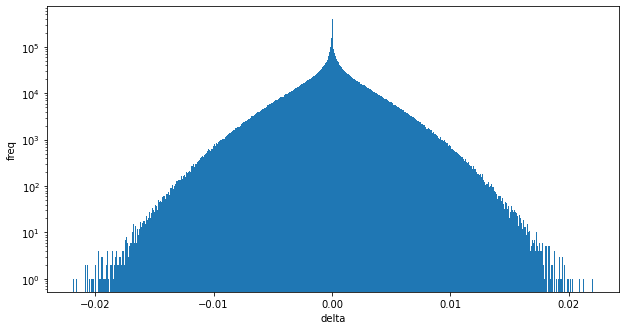

In [42]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.hist(deltas, bins= 615)
ax.set_yscale('log')
ax.set_ylabel(r'freq', usetex = False)
ax.set_xlabel(r'delta', usetex = False)
fig.set_size_inches(11.75-1.5, 8.25-2 - 1)

We get the periodogram. Note that the periodogram is the abs(f)^2.


Spectral Signal
Largest/peak frequency found at 249.99975 kHz


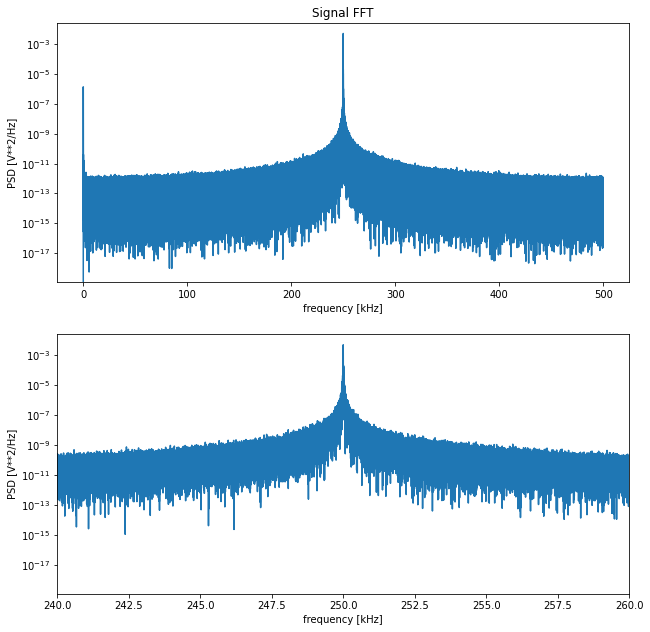

In [43]:
fig, axs = plt.subplots(nrows=2, ncols=1)
f, power_den = periodogram(signal, SAMPLING_F)
print('\nSpectral Signal')
print(f"Largest/peak frequency found at {f[np.argmax(power_den)]/1e3} kHz")
ax = axs[0]
ax.semilogy(f[0:]/1e3, power_den[0:])
# ax.set_xscale('log')
ax.set_ylim(min(power_den[1:])/5, max(power_den[1:])*5)
ax.set_xlabel('frequency [kHz]')
ax.set_ylabel('PSD [V**2/Hz]')
ax.set_title('Signal FFT')
ax = axs[1]
ax.semilogy(f[0:]/1e3, power_den[0:])
# ax.set_xscale('log')
ax.set_ylim(min(power_den[1:])/5, max(power_den[1:])*5)
ax.set_xlabel('frequency [kHz]')
ax.set_ylabel('PSD [V**2/Hz]')
if N == 4:
    ax.set_xlim(240, 260)
elif N == 8:
    ax.set_xlim(115, 135)

fig.set_size_inches(11.75-1.5, 2*(8.25-2 - 1))

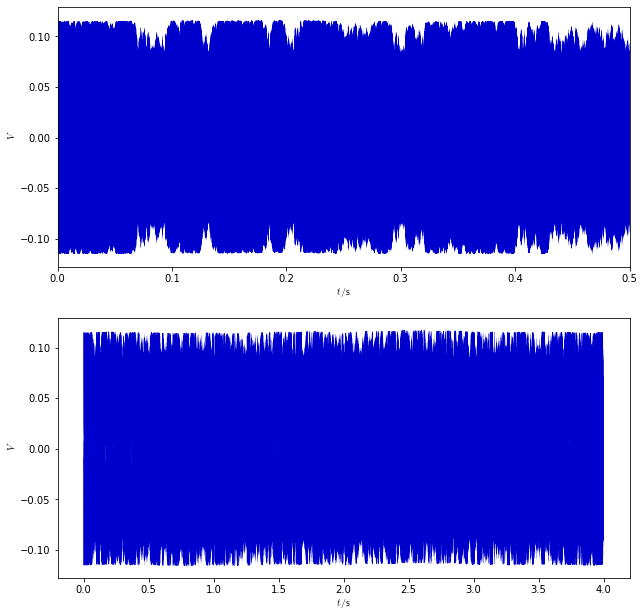

In [44]:
fig, axs = plt.subplots(nrows=2, ncols=1)
ax = axs[0]
ax.plot(t_axis, signal, color = 'mediumblue', linewidth= 0.1)
ax.set_ylabel(r'$V$', usetex = True)
ax.set_xlabel(r'$t$/s', usetex = True)
ax.set_xlim(0, 0.5)
ax = axs[1]
ax.plot(t_axis, signal, color = 'mediumblue', linewidth= 0.1)
ax.set_ylabel(r'$V$', usetex = True)
ax.set_xlabel(r'$t$/s', usetex = True)
fig.set_size_inches(11.75-1.5, (8.25-2 - 1)*2)

In [45]:
radii = get_R_signal(signal, N, ph_ad)

Text(0.5, 0, '$t$/s')

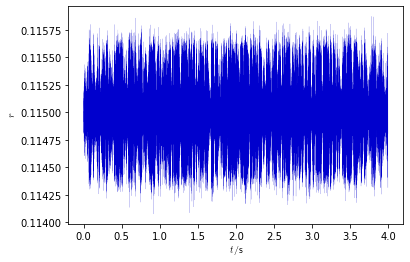

In [46]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(t_axis[N-1:], radii, color = 'mediumblue', linewidth= 0.1)
ax.set_ylabel(r'$r$', usetex = True)
ax.set_xlabel(r'$t$/s', usetex = True)
